In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np

import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
import glob

from torchvision import datasets, transforms
from src.models import linear_vanilla_vae, denoising_vanilla_vae, training
from src.features import dataLoader as MyDataLoader

from src.features import utils
import pathlib
import PIL
from torchvision.transforms import ToTensor, ToPILImage

import matplotlib.pyplot as plt
import yaml

import json
from math import log10, sqrt
import os
from imageaugment import augment
from tqdm import tqdm

In [120]:
def getStdImage(img, vae):    
    
    samples=1
    img_height,img_width=img.shape[0],img.shape[1]
    img_t = torch.Tensor(img)
    image_sample = img_t.view(1,1,img.shape[0], img.shape[1]).cuda()

    akku=np.zeros((img_height,img_width))
    akku_std = np.zeros((img_height,img_width))
    for i in tqdm(range(samples)):
        mu, sigma, recon_, logvar = vae(image_sample)
        #z=mu
        recon = (recon_* vae.data_std)+vae.data_mean 
        std = torch.sqrt(torch.exp(logvar))*vae.data_std
        recon_cpu = recon.cpu()
        recon_numpy = recon_cpu.detach().numpy()
        recon_numpy.shape=(img_height,img_width) 
        akku+=recon_numpy
        std_numpy = std.cpu().detach().numpy()
        std_numpy.shape=(img_height,img_width) 
        akku_std+=std_numpy
    akku=akku/float(samples)
    akku_std=akku_std/float(samples)
    return akku, akku_std

In [2]:
from tifffile import imread
observation= imread('/home/fahad/master_thesis/vanilla_vae/data/raw/Convallaria_diaphragm/20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')

In [3]:
dataTest=imread('/home/fahad/master_thesis/vanilla_vae/data/raw/Convallaria_diaphragm/20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')[:,:512,:512] 

In [4]:
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]

In [45]:
dataTestGT.shape

(1, 512, 512)

In [17]:
train_patches, val_patches = utils.get_trainval_patches(observation,augment=True,patch_size=128,num_patches=100)
x_train_tensor, x_val_tensor, data_mean, data_std = utils.preprocess(train_patches, val_patches,  True)

In [ ]:
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, dataTest, dataTestGT)

In [22]:
net = torch.load("/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/Convallaria/exp_20/checkpoints/epoch-195.net")
test_image = dataTest[0].astype("float32")
image_sample = ToTensor()(test_image).view(1,1,512,512).cuda()
output = utils.predictMMSE(image_sample, 1, net, (512,512), True)

AttributeError: 'DataParallel' object has no attribute 'encode'

In [28]:
vmi=np.percentile(dataTestGT[0],0.01)
vma=np.percentile(dataTestGT[0],99)

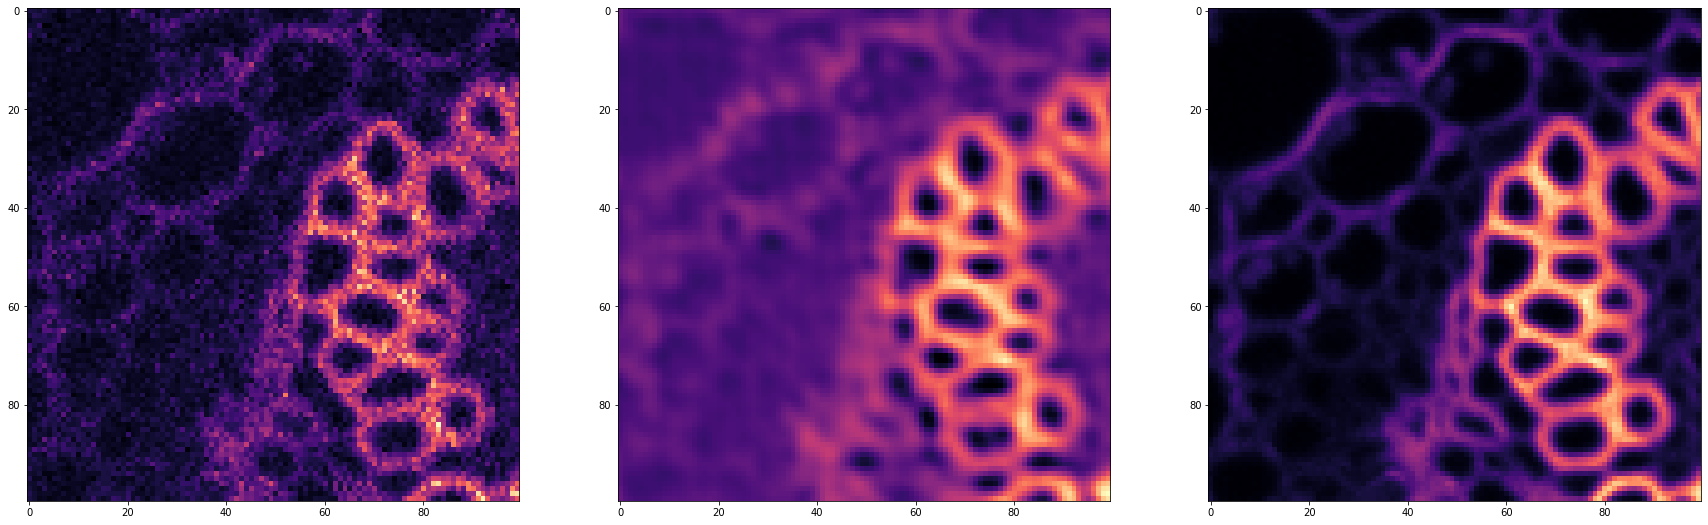

In [44]:
minVal, maxVal = 234, 7402
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.imshow(dataTest[0][100:200,150:250], cmap='magma')

plt.subplot(1, 3, 2)
plt.imshow(output[100:200,150:250], cmap='magma')

plt.subplot(1, 3, 3)
plt.imshow(dataTestGT[0][100:200,150:250], cmap='magma')
plt.show()

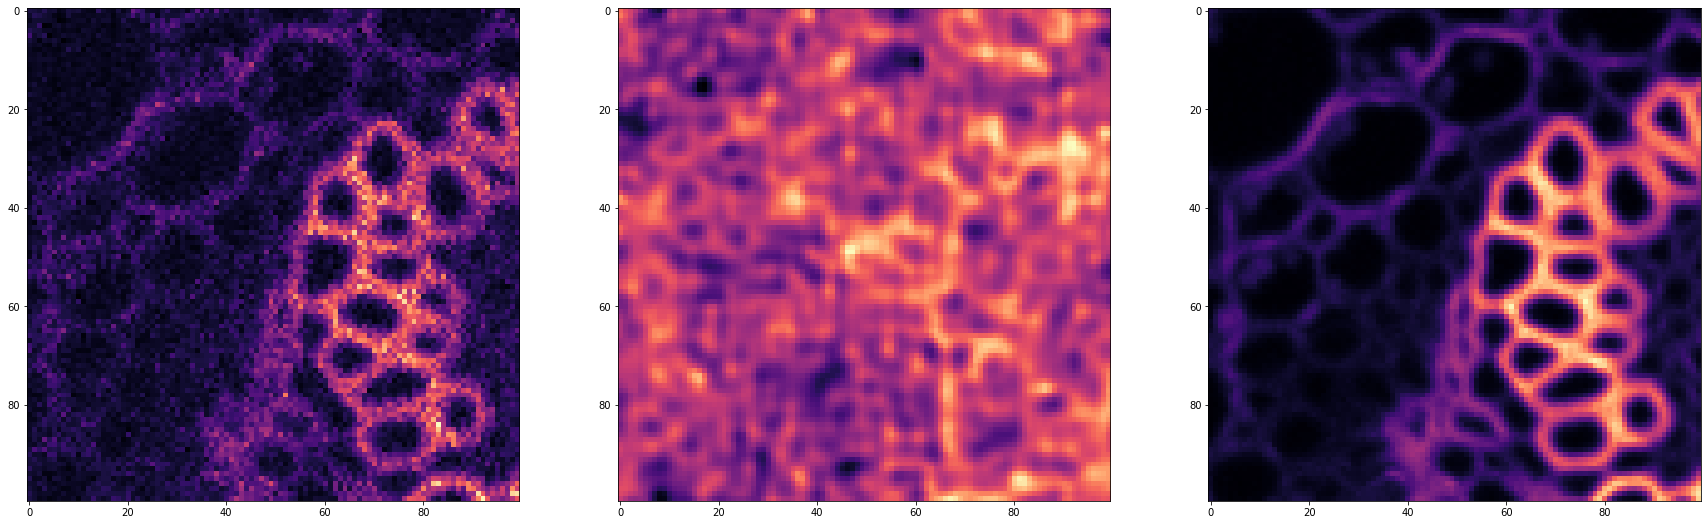

In [36]:
#minVal, maxVal = 234, 7402
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.imshow(dataTest[0][100:200,150:250], cmap='magma')

plt.subplot(1, 3, 2)
plt.imshow(output[100:200,150:250], cmap='magma')

plt.subplot(1, 3, 3)
plt.imshow(dataTestGT[0][100:200,150:250], cmap='magma')
plt.show()

In [40]:
particledensity = .005
utils.image_transform(
    images_paths_list=val_images_path_list,
    seed=config_file["seed"],
    particle_noise_density=config_file["particle_noise_density"],
    transform=config_file["transform"],
    gaussian=config_file["gaussian"],
    clip=config_file["clip"],
)
image = PIL.Image.open("/home/fahad/master_thesis/vanilla_vae/data/raw/simulated_clean_templates/val/8_0_.png")
image = add_noise(image, particledensity)

In [35]:
def add_noise(image, particledensity):
    number = int(particledensity * image.width * image.height)
    top = np.random.uniform(low=0, high=(image.height-1), size=number)
    left = np.random.uniform(low=0, high=(image.width-1), size=number)
    image_array = np.array(image)
    for i in range(number):
        if (top[i]<image.height) and (left[i]<image.width):
            if (image_array[int(top[i])+1][int(left[i])]==255) and (image_array[int(top[i])][int(left[i])+1]==255) and (image_array[int(top[i])+1][int(left[i])+1]==255) and (image_array[int(top[i])-1][int(left[i])]==255) and (image_array[int(top[i])][int(left[i])-1]==255) and (image_array[int(top[i])-1][int(left[i])-1]==255) and (image_array[int(top[i])-1][int(left[i])+1]==255) and (image_array[int(top[i])+1][int(left[i])-1]==255):
                image_array[int(top[i])][int(left[i])] = image_array[int(top[i])][int(left[i])] - 255
    
    return PIL.Image.fromarray(image_array)

In [2]:
data_directory = "/home/fahad/master_thesis/vanilla_vae/data/raw/simulated_clean_templates/"
save_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/"
images_folder_path = pathlib.Path(data_directory) / "val"
#test_image_sequence = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
test_image_sequence = [0.2, 0.4, 0.6, 0.8, 1.0]
#test_image_sequence = [1.2, 1.4, 1.6, 1.8, 2.0]
z_dim = 8
in_channels = 1
init_filters = 32
n_filters_per_depth = 2
n_depth = 2
bias = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = denoising_vanilla_vae.VAE(
    z_dim=z_dim,
    in_channels=in_channels,
    init_filters=init_filters,
    n_filters_per_depth=n_filters_per_depth,
    n_depth=n_depth,
    bias=bias,
)

In [ ]:
image_path = utils.load_paths(
    data_directory=images_folder_path,
    n_samples=101,
)[100]

ground_truth = utils.image_transform(
    images_paths_list=[image_path],
    transform=False,
    seed=None
)[0]
loss = []
recon_list = []
for sequence in test_image_sequence:
    test_image = utils.image_transform(
        images_paths_list=[image_path],
        particle_noise_density=sequence,
        transform=True,
        seed=None
    )[0]

    width, height = test_image.size
    image_sample = ToTensor()(test_image).view(1,1,height,width).to(device)
    
    image = image_sample.cpu().detach().numpy()*255

    image = np.squeeze(image, axis=1)
    mean, std = np.mean(image), np.std(image)
    
    net.data_mean = torch.Tensor([mean/255.0]).to(device)
    net.data_std = torch.Tensor([std/255.0]).to(device)
    x = (image_sample-net.data_mean) / net.data_std
    mu, sigma = net.encoder(x)
    z = net.reparameterize(mu, sigma)
    recon, logvar_decoder = net.decoder(z)
    loss.append(training.loss_fn(recon, x, mu, sigma, logvar_decoder, net.data_std))
    recon_list.append(recon)

/home/fahad/miniconda3/envs/vanilla_vae/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
np.max(np.squeeze(np.array(recon_list[4].cpu().detach().numpy()))*255)

-5.4159904

In [ ]:
test_image = utils.image_transform(
    images_paths_list=[image_path],
    particle_noise_density=0.4,
    transform=True,
    seed=None
)[0]
test_image

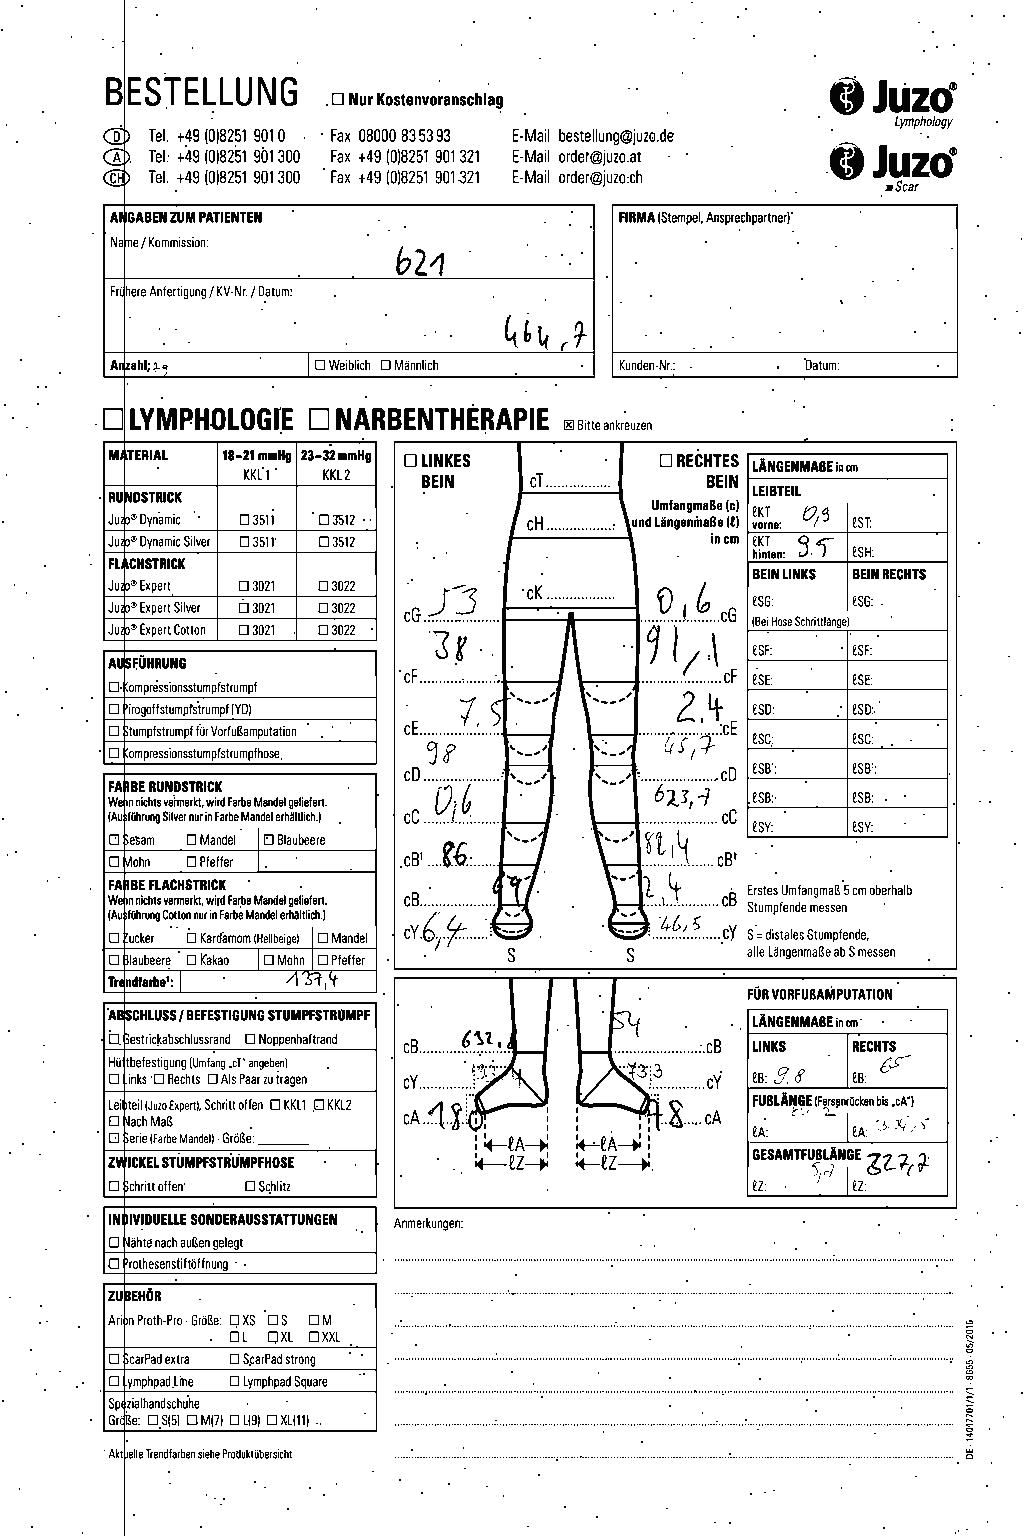

In [25]:
test_image = utils.image_transform(
    images_paths_list=[image_path],
    particle_noise_density=0.2,
    transform=True,
    seed=None
)[0]
test_image

In [ ]:
PIL.Image.fromarray(np.squeeze(np.array(recon_list[4].cpu().detach().numpy()))*255).convert("L")

In [3]:
loss

[(tensor(0.5008, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5008, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5008, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5008, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5008, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>))]

In [3]:
loss

[(tensor(0.5003, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5003, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5003, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5003, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)),
 (tensor(0.5003, device='cuda:0', grad_fn=<NegBackward>),
  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>))]

# PSNR Plot Across One Experiment

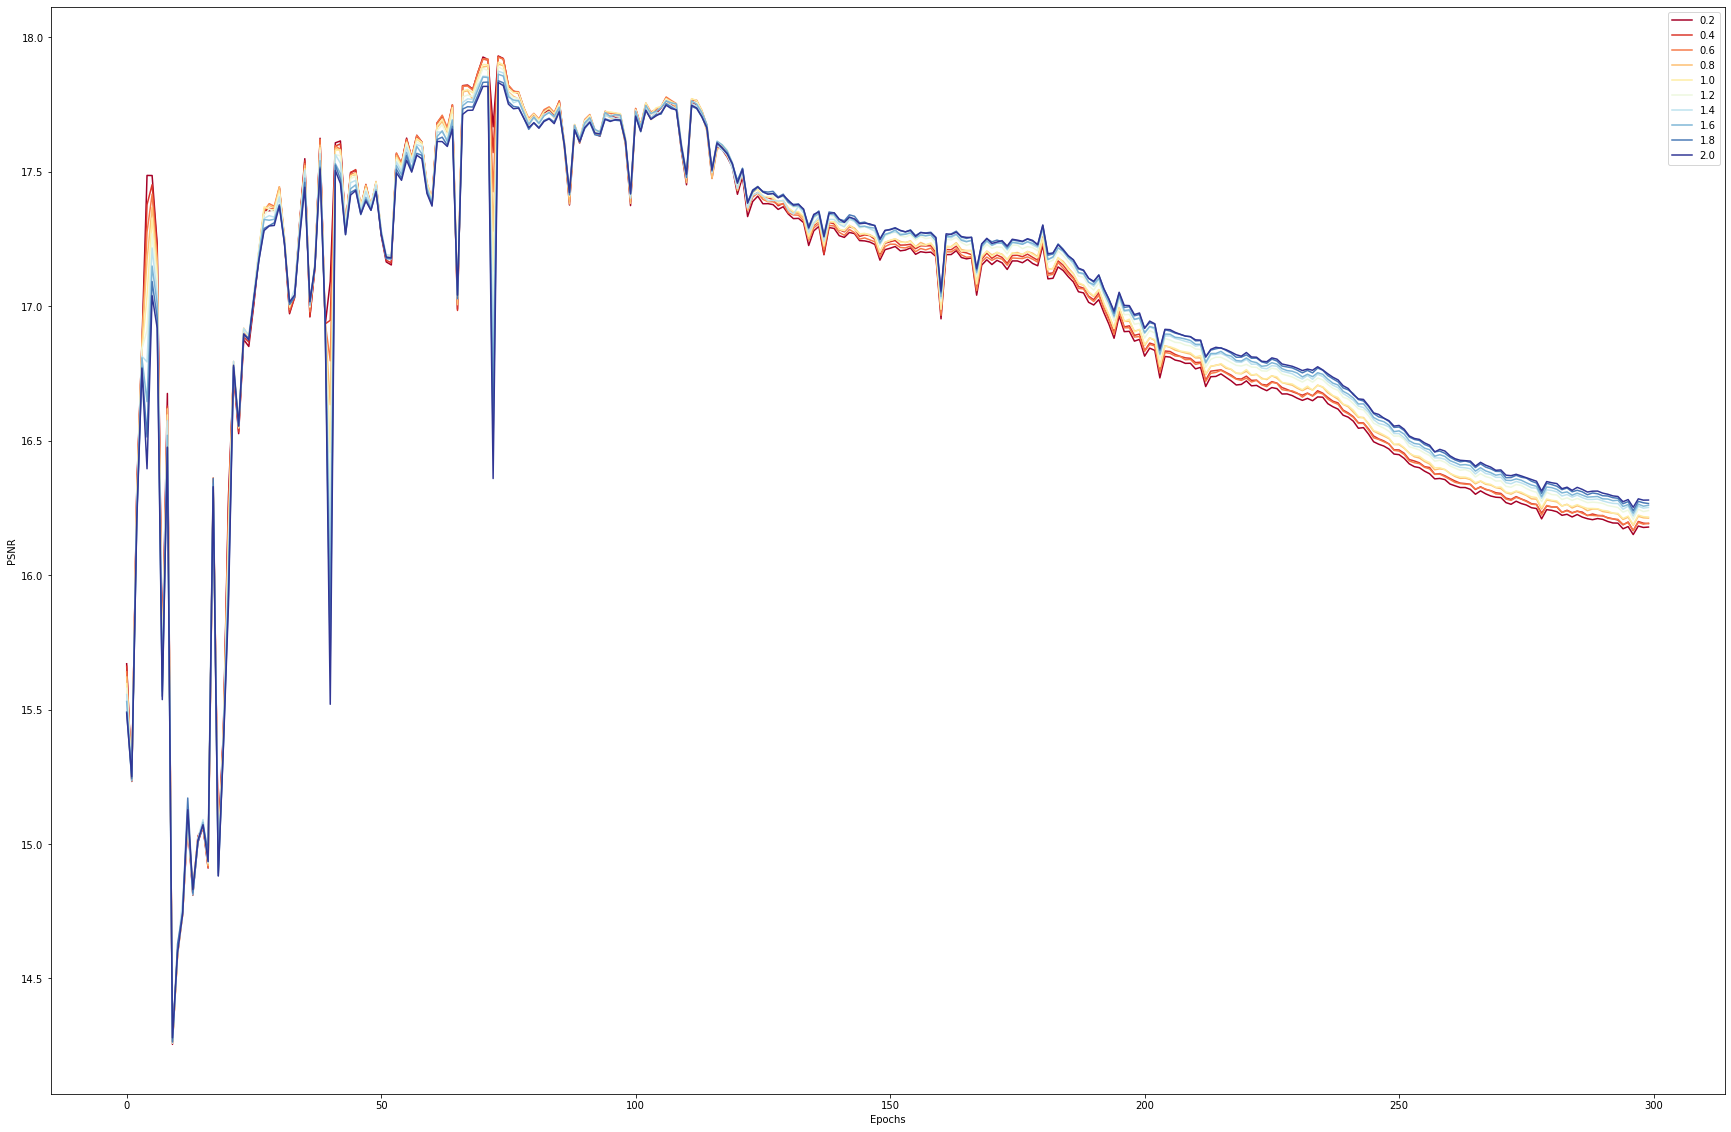

In [152]:
directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/exp_13/plots/"
sequence = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
fig1 = plt.figure(figsize=(30,20))
ax1 = fig1.add_subplot(111)
#ax1.set_yticks(np.arange(14.0, 17.0, .1))
for i in sequence:
    data = np.load(directory_path + str(i) + "psnr_data.npy")
    ax1.plot(data,label=i)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("PSNR")
colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
ax1.legend()

# Normal Plots

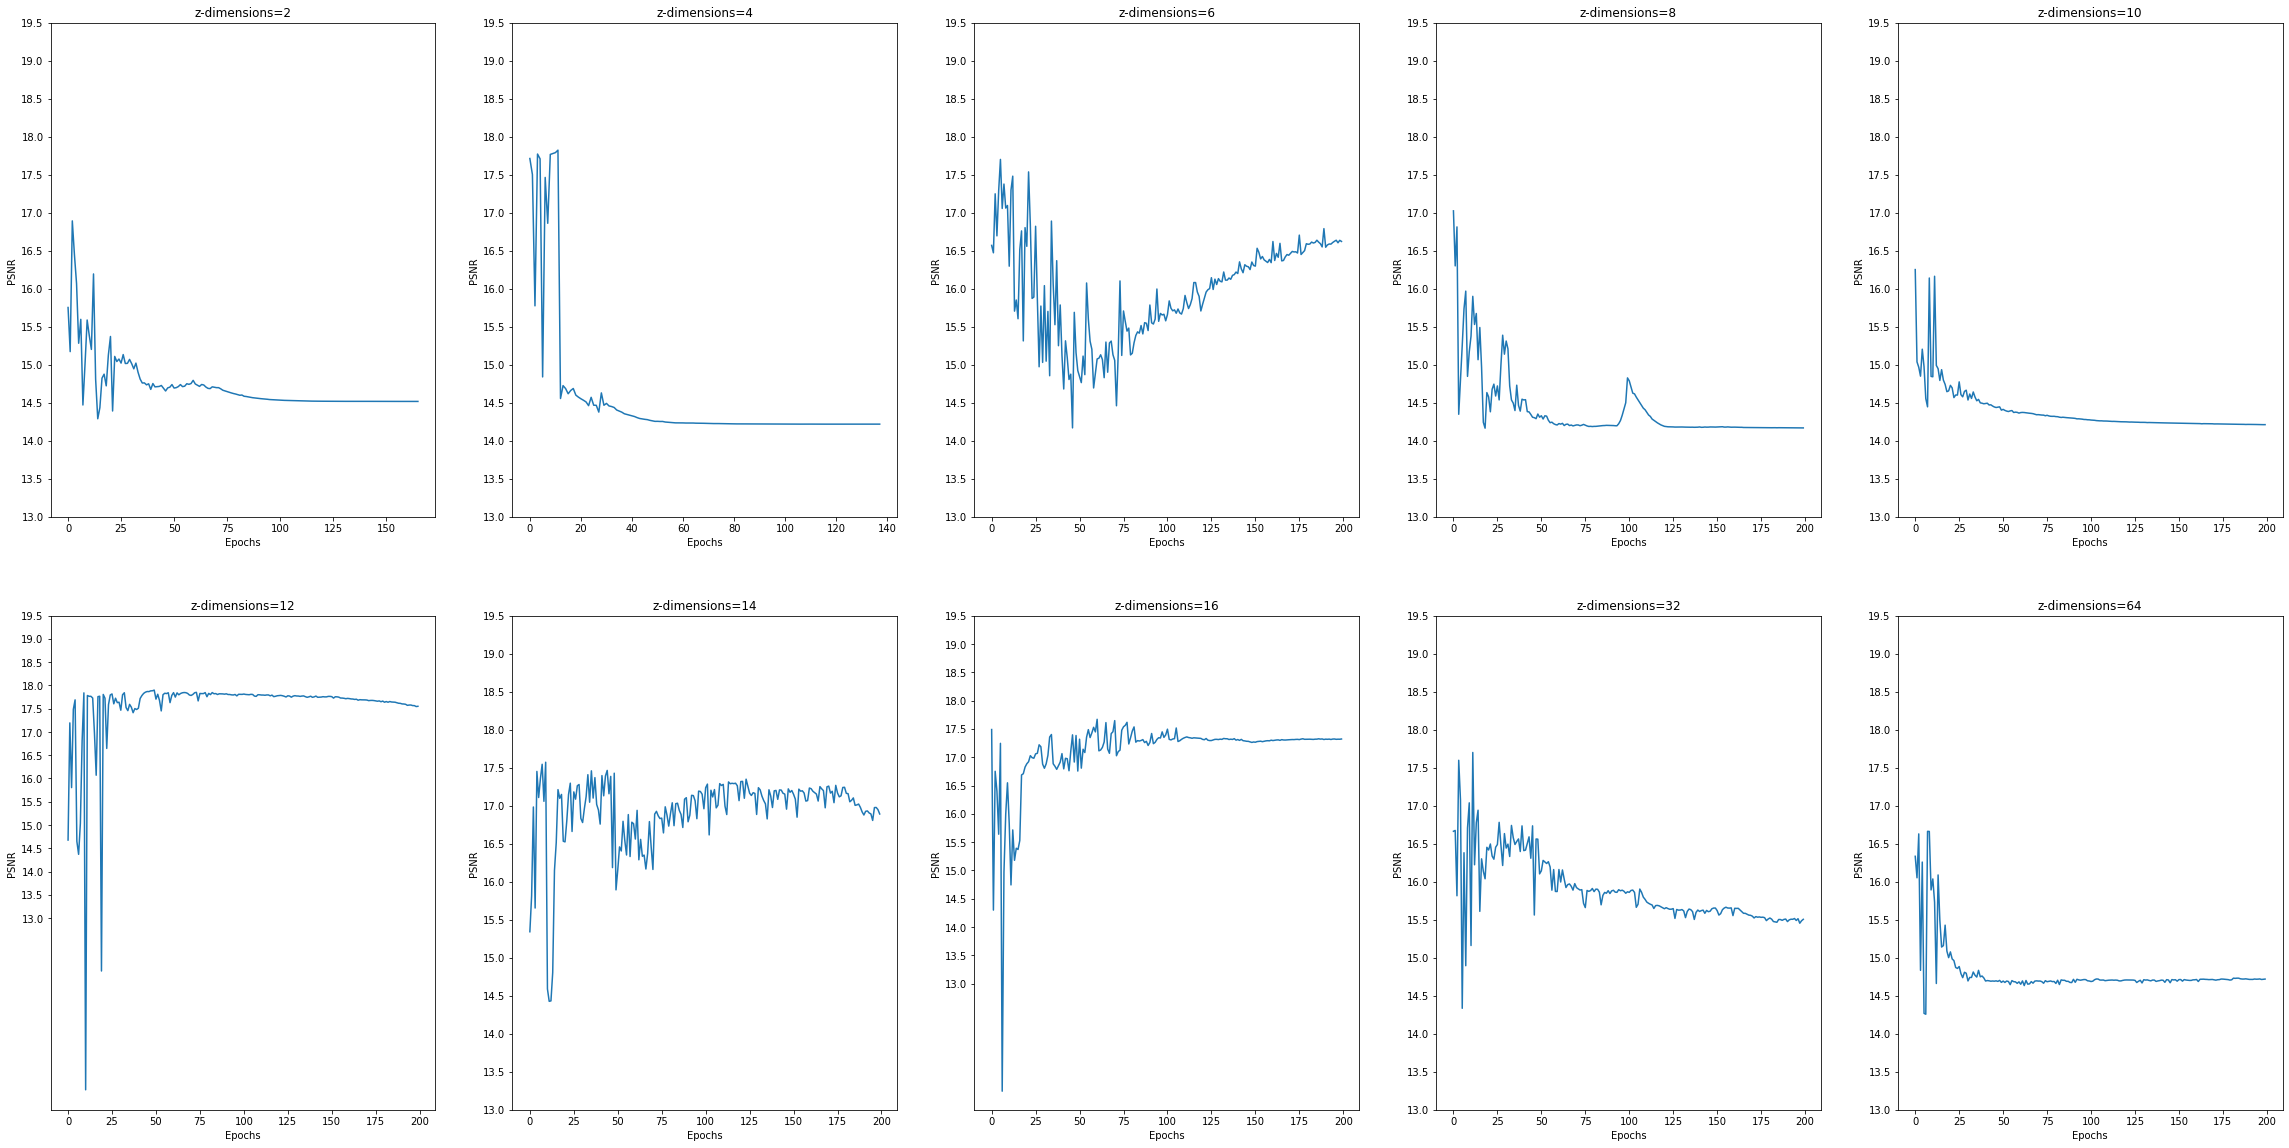

In [58]:
exp = ["14", "15", "16", "01", "17", "18", "19", "03", "05", "07"]
z_dim = ["2", "4", "6", "8", "10", "12", "14", "16", "32", "64"]
y=[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
x=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(40,20))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/exp_" + j + "/plots/"
    data = np.load(directory_path + "1.0psnr_data.npy")
    ax[h, i].plot(data)
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_yticks(np.arange(13.0, 20.0, .5))
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("PSNR")
plt.show()

In [91]:
CONFIG_PATH = "/home/fahad/master_thesis/vanilla_vae/experiments/"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config_file = yaml.safe_load(file)

    return config_file

config_file = load_config("exp_17" + ".yaml")
checkpoints_path = os.path.join(config_file["save_default_path"], config_file["title"]) + "/checkpoints/"
plots_path = os.path.join(config_file["save_default_path"], config_file["title"]) + "/plots/"
images_folder_path = pathlib.Path(config_file["data_directory"]) / "val"

image_path = utils.load_paths(
    data_directory=images_folder_path,
    n_samples=101,
)[100]

ground_truth = utils.image_transform(
    images_paths_list=[image_path],
    transform=False,
    seed=config_file["seed"]
)[0]

test_image = utils.image_transform(
    images_paths_list=[image_path],
    particle_noise_density=2.0,
    transform=True,
    seed=config_file["seed"]
)[0]

width, height = test_image.size
image_sample = ToTensor()(test_image).view(1,1,height,width).cuda()

net = torch.load(checkpoints_path + "epoch-" + "199" + ".net")
output = utils.predictMMSE(image_sample, 10, net, size=(height, width))

In [82]:
hist, bin_edges = np.histogram(output, density=False)

array([241.04824153, 241.55499449, 241.97512123, ..., 255.44885623,
       255.46504033, 255.4659462 ])

(array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+01,
         1.526e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.200e+01, 1.200e+01,
         1.507e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.000e+00,
         1.533e+03],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.000e+00, 2.100e+01,
         1.509e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.000e+00, 1.500e+01,
         1.516e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 7.000e+00, 1.500e+01,
         1.502e+03]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1024 BarContainer objects>)

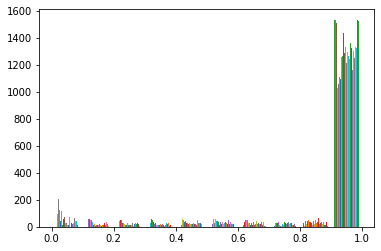

In [89]:
import matplotlib.pyplot as plt
plt.hist(img_rescale)

In [ ]:
from skimage import exposure
p2, p98 = np.percentile(output, (10, 90))
img_rescale = exposure.rescale_intensity(output, in_range=(p2, p98))
img_adapteq = exposure.equalize_adapthist(output, clip_limit=0.03)

In [103]:
NR_OF_GRAY = 2 ** 14
image = np.round(exposure.rescale_intensity(output, out_range=(0, NR_OF_GRAY - 1))).astype(np.uint16)

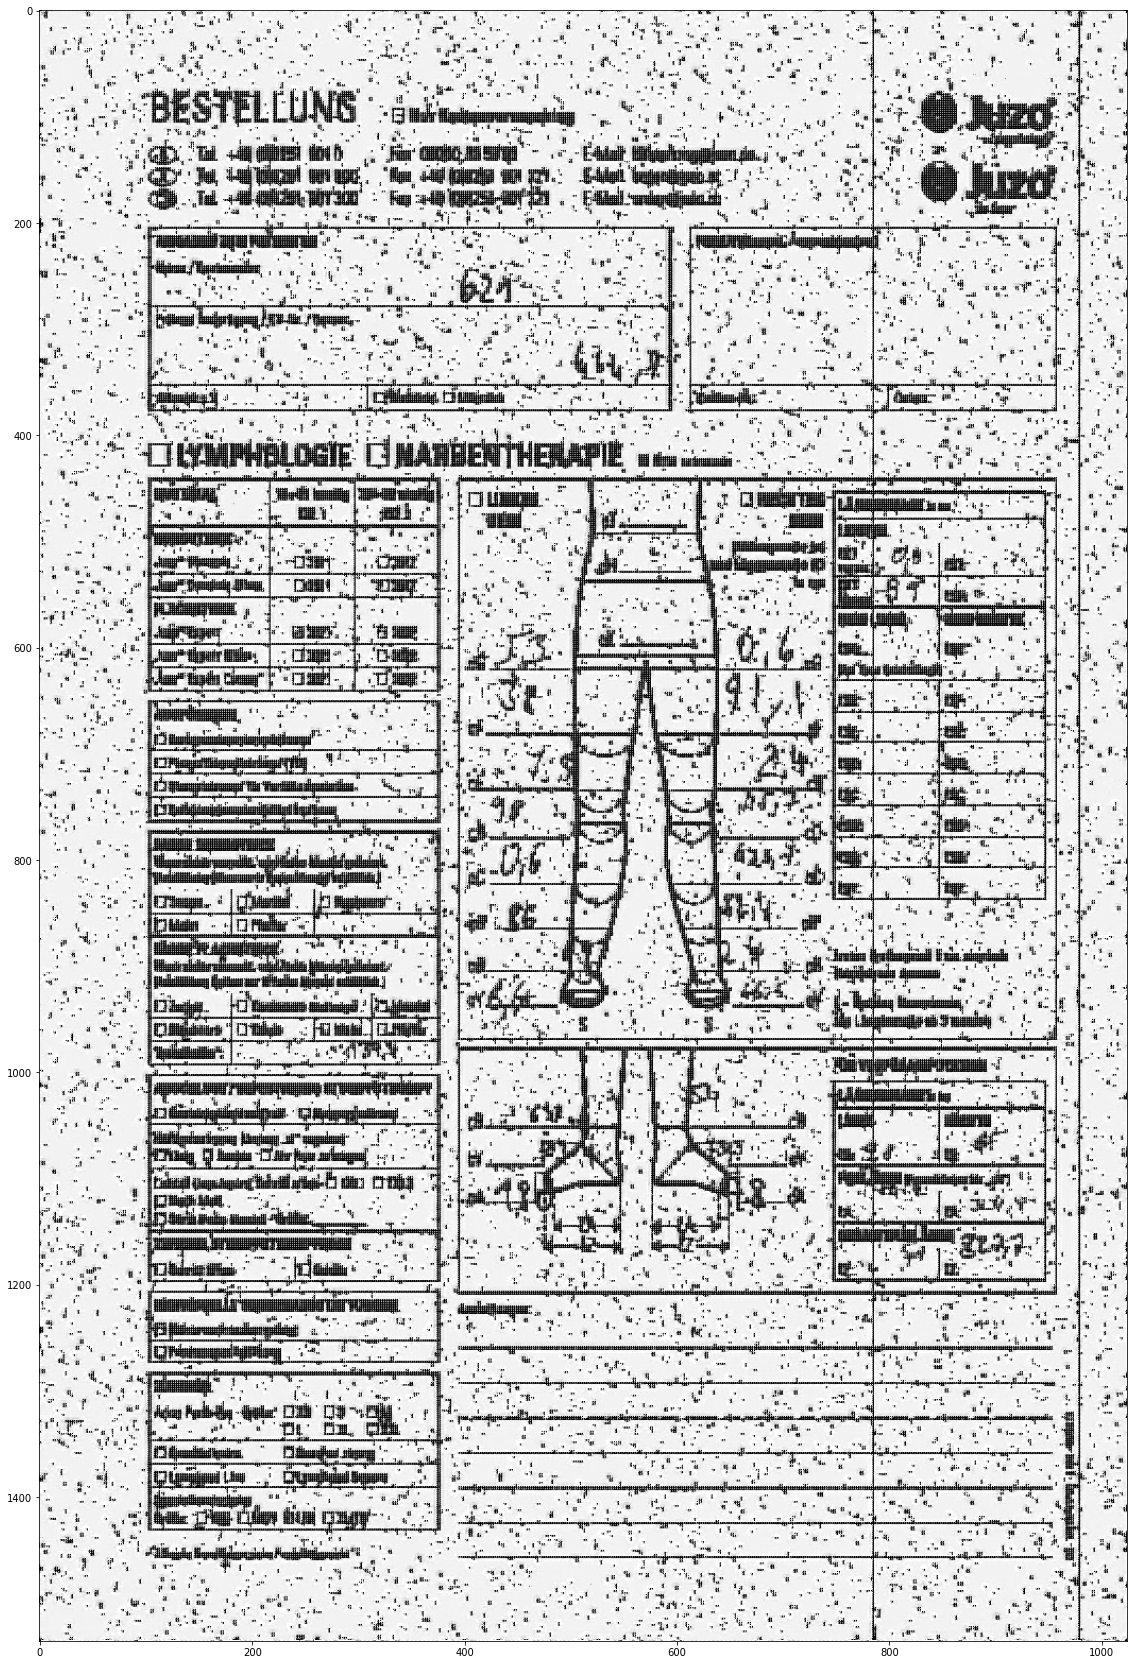

In [107]:
plt.figure(figsize=(60, 30))
plt.imshow(img_rescale, cmap='gray') 
plt.show()

In [77]:
np.array(ground_truth) - output

array([[ 5.68253428e+00,  2.00620115e-01, -1.60670578e-02, ...,
         2.19081044e-02,  3.03074777e-01,  2.84456536e+00],
       [ 2.85921890e+00,  9.80595142e-01, -3.64628434e-03, ...,
         2.81732082e-02, -2.71031857e-02,  1.88049021e+00],
       [ 2.63672259e+00, -8.76232982e-02, -1.51292682e-01, ...,
         1.64971948e-02,  6.41131997e-02,  3.08646798e-01],
       ...,
       [ 8.89349878e-01,  1.24447882e-01,  1.93803281e-01, ...,
        -5.05768061e-02, -2.53522396e-03,  1.56457821e+00],
       [ 1.08600909e+00,  1.35302380e+00,  1.64447576e-01, ...,
         8.37520659e-02,  1.13667101e-01,  2.54457906e+00],
       [ 5.20741841e+00,  9.65908170e-03,  8.44266057e-01, ...,
         8.36365521e-01,  3.32152337e-01,  5.65969294e+00]])

In [28]:
np.array(ground_truth, dtype='float64') - output

array([[ 4.39716813,  5.31196144,  5.29053211, ...,  6.54199192,
         6.45880982, 10.45653275],
       [ 1.08186427,  0.43540648,  0.0155746 , ..., -0.06178468,
         0.72657877,  3.70957223],
       [-0.02052802, -0.02699071, -0.03865761, ...,  1.31343752,
         0.33972913,  4.01407877],
       ...,
       [ 0.0746356 , -0.05831623,  0.1438922 , ...,  0.40321916,
         0.08825558,  4.52782944],
       [ 0.74506402,  0.99893752,  0.35478848, ...,  0.03626525,
         0.31261379,  2.68279588],
       [ 9.57475662, 11.06040394, 12.42511743, ..., 10.88609514,
        10.52687913, 14.03919178]])

In [33]:
max(np.unique(np.array(ground_truth, dtype='float64')))

255.0

In [61]:
output

array([[250.60283187, 249.68803856, 249.70946789, ..., 248.45800808,
        248.54119018, 244.54346725],
       [253.91813573, 254.56459352, 254.9844254 , ..., 255.06178468,
        254.27342123, 251.29042777],
       [255.02052802, 255.02699071, 255.03865761, ..., 253.68656248,
        254.66027087, 250.98592123],
       ...,
       [254.9253644 , 255.05831623, 254.8561078 , ..., 254.59678084,
        254.91174442, 250.47217056],
       [254.25493598, 254.00106248, 254.64521152, ..., 254.96373475,
        254.68738621, 252.31720412],
       [245.42524338, 243.93959606, 242.57488257, ..., 244.11390486,
        244.47312087, 240.96080822]])

# Bias-Free Plots


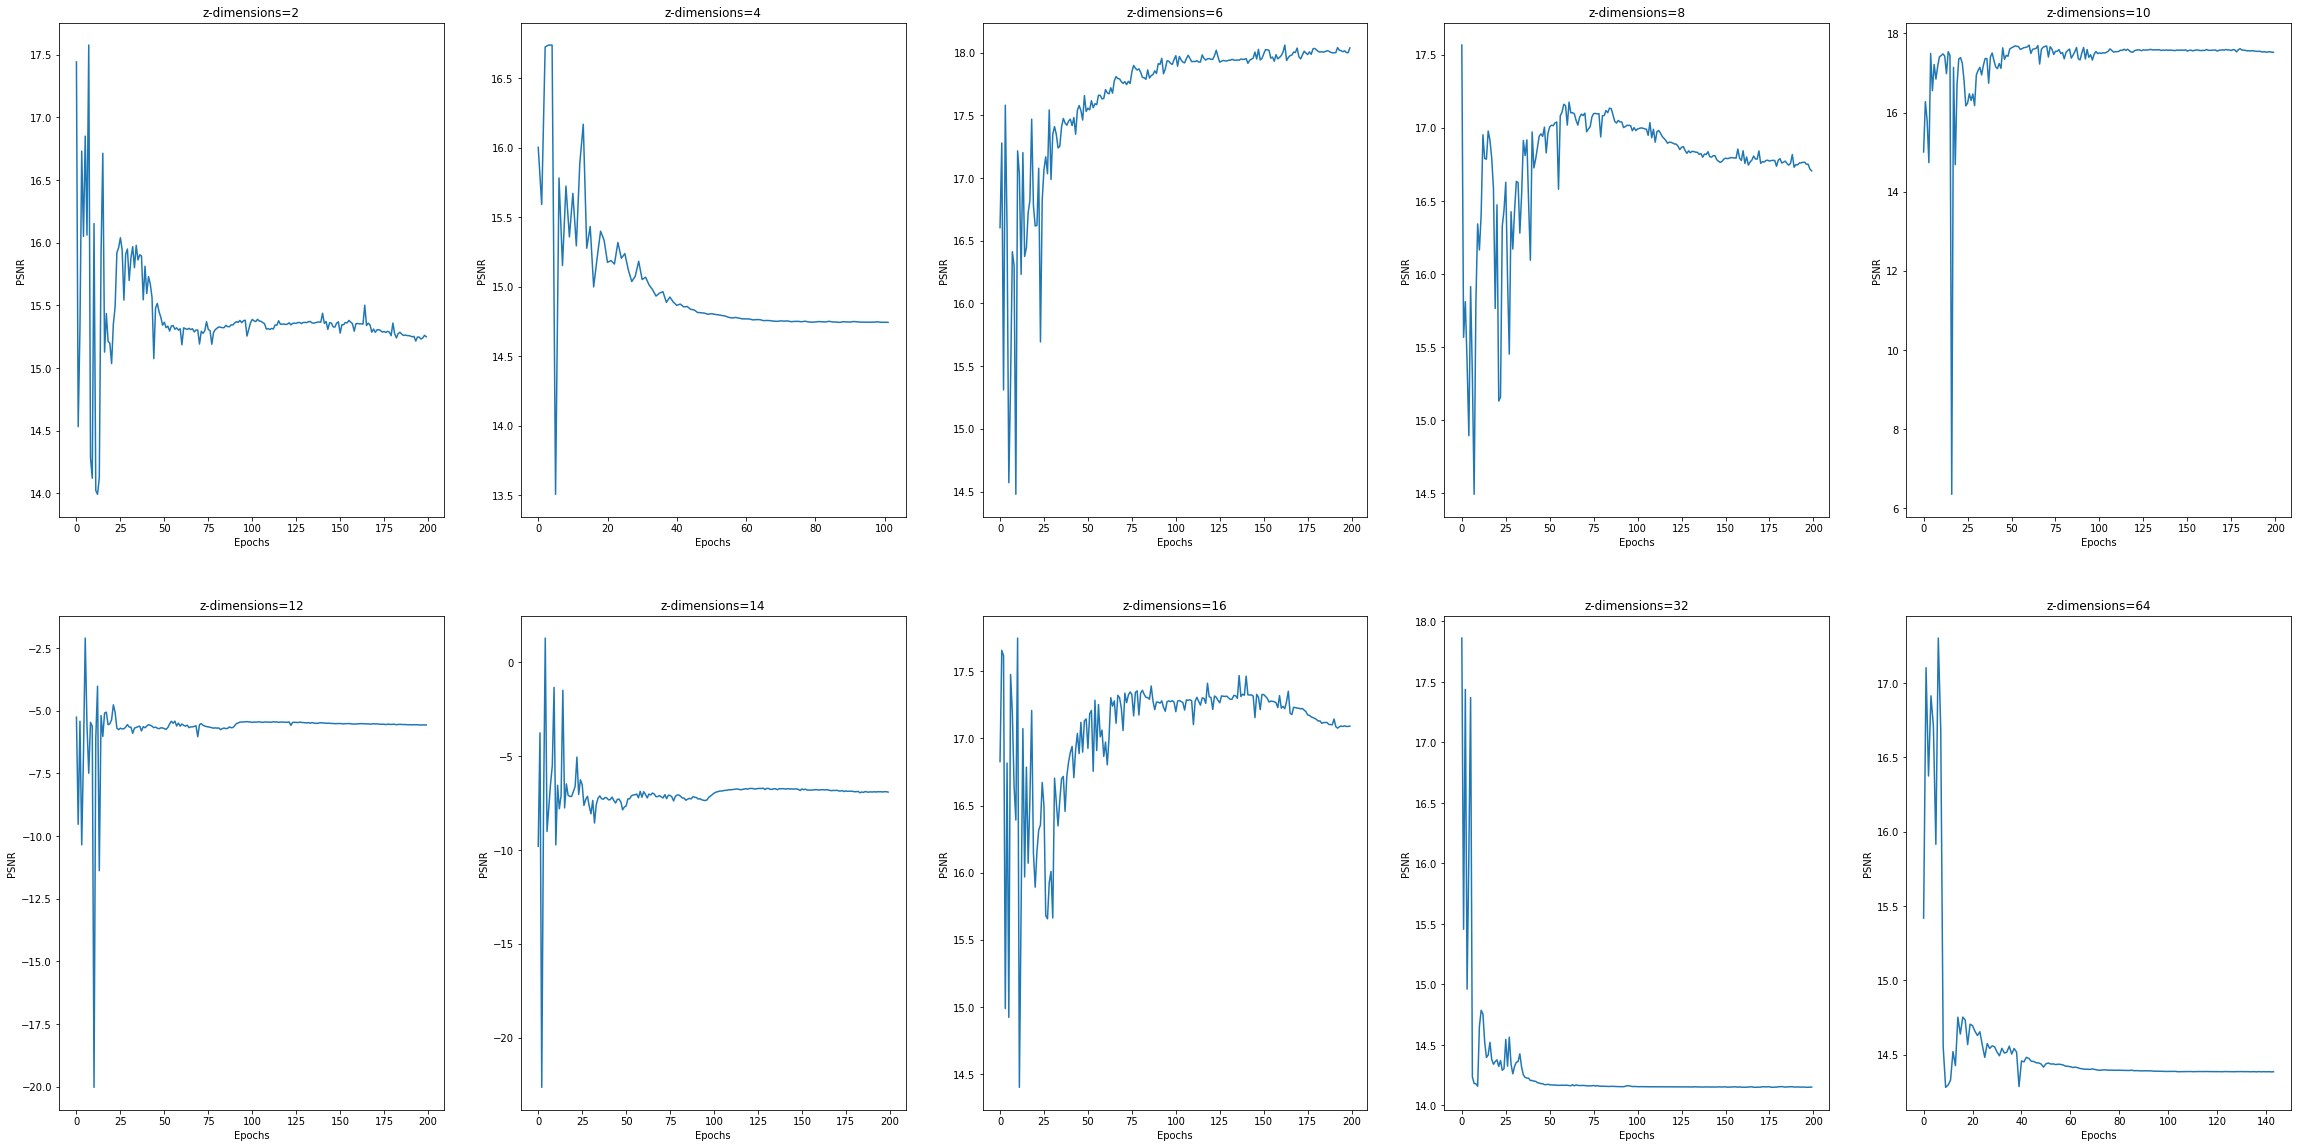

In [57]:
exp = ["14", "15", "16", "01", "17", "18", "19", "03", "05", "07"]
z_dim = ["2", "4", "6", "8", "10", "12", "14", "16", "32", "64"]
y=[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
x=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(40,20))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/Bias_Free/exp_" + j + "/plots/"
    data = np.load(directory_path + "1.0psnr_data.npy")
    ax[h, i].plot(data)
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("PSNR")
plt.show()

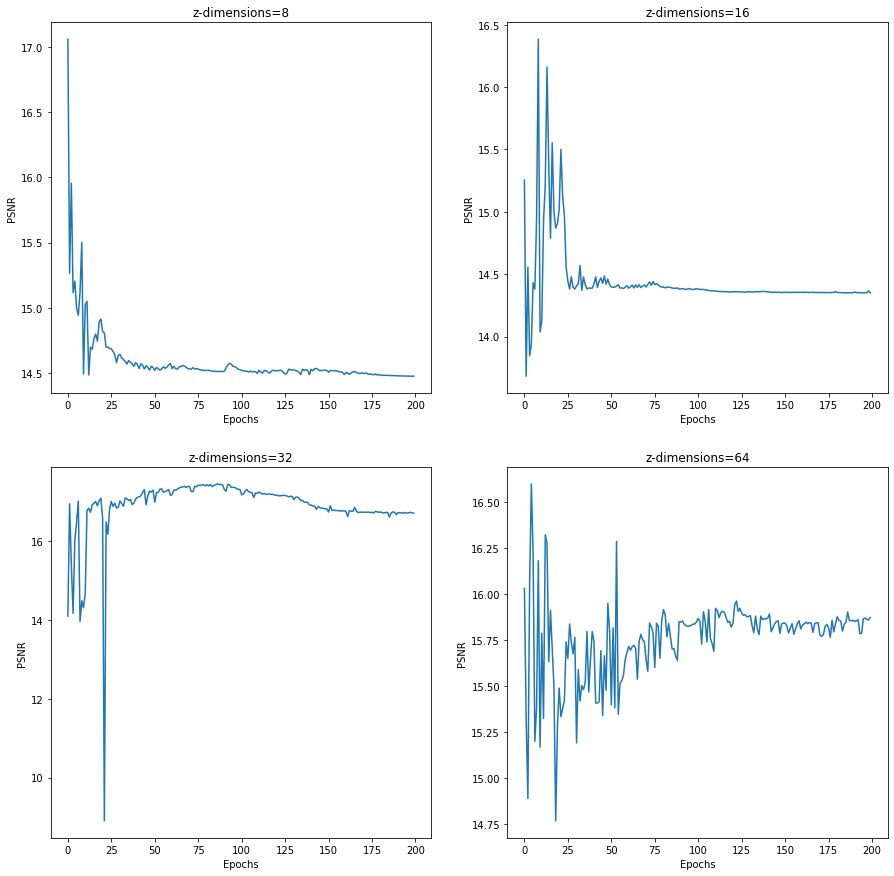

In [147]:
exp = ["02", "04", "06", "08"]
z_dim = ["8", "16", "32", "64"]
x=[0, 0, 1, 1]
y=[0, 1, 0, 1]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v3/exp_" + j + "/plots/"
    data = np.load(directory_path + "2.0psnr_data.npy")
    ax[h, i].plot(data)
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("PSNR")
plt.show()

## For Plain and Gaussian

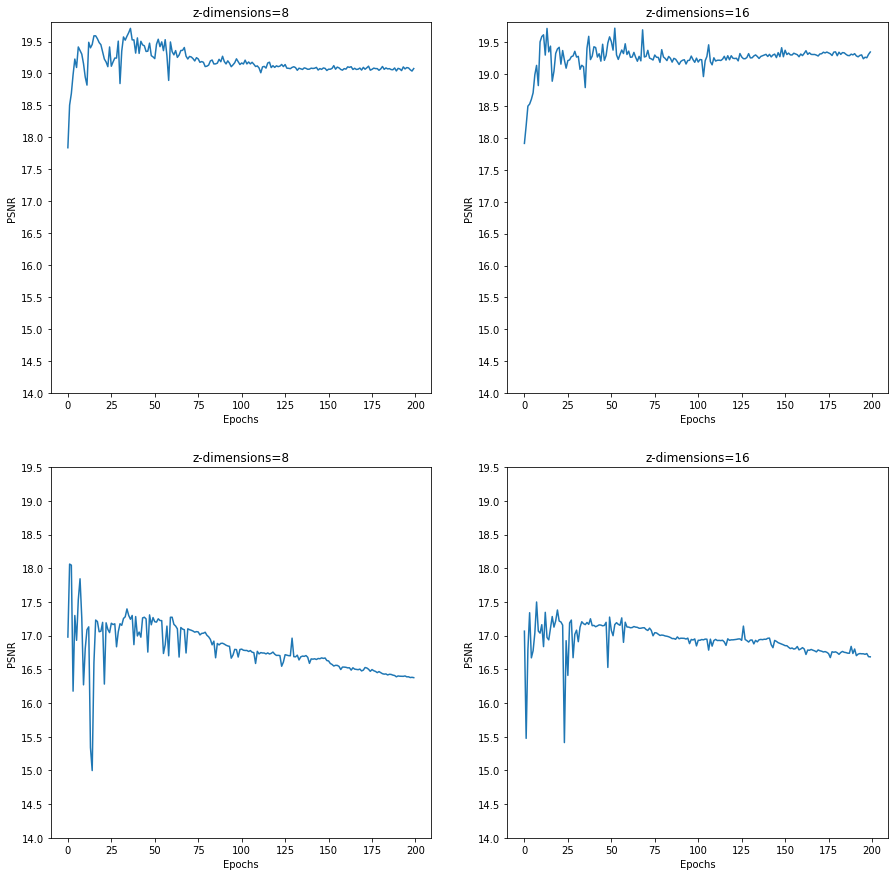

In [35]:
exp = ["09", "10", "11", "12"]
z_dim = ["8", "16", "8", "16"]
x=[0, 0, 1, 1]
y=[0, 1, 0, 1]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v2/exp_" + j + "/plots/"
    data = np.load(directory_path + "1.0psnr_data.npy")
    ax[h, i].plot(data)
    ax[h, i].set_yticks(np.arange(14.0, 20.0, .5))
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("PSNR")
plt.show()

# Loss Plots

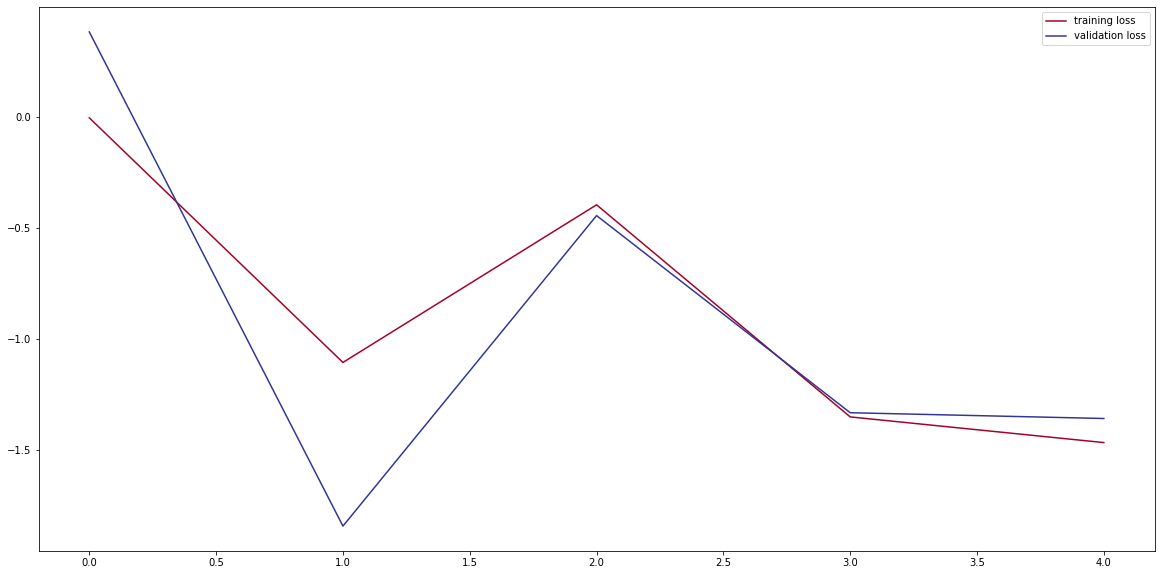

In [2]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(111)
#ax1.set_yticks(np.arange(14.0, 17.0, .1))
directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/exp_14/plots/"
data = np.load(directory_path + "train_loss.npy")
ax1.plot(data,label='training loss')
data = np.load(directory_path + "val_loss.npy")
ax1.plot(data,label='validation loss')
colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
ax1.legend()

## For Plain and Gaussian

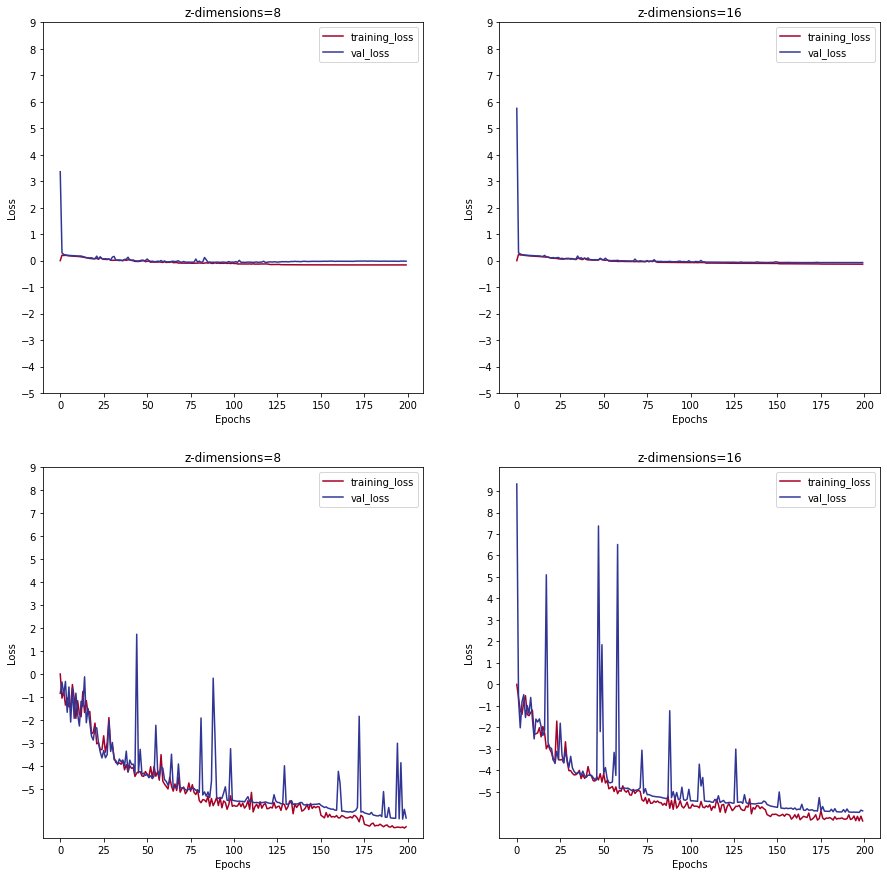

In [59]:
exp = ["09", "10", "11", "12"]
z_dim = ["8", "16", "8", "16"]
x=[0, 0, 1, 1]
y=[0, 1, 0, 1]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v2/exp_" + j + "/plots/"
    data = np.load(directory_path + "train_loss.npy")
    ax[h, i].plot(data,label="training_loss")
    data = np.load(directory_path + "val_loss.npy")
    ax[h, i].plot(data,label="val_loss")
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("Loss")
    ax[h, i].set_yticks(np.arange(-5.0, 10.0, 1.0))
    colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1,len(ax[h, i].lines))]
    for a,b in enumerate(ax[h, i].lines):
        b.set_color(colors[a])
    ax[h, i].legend()
plt.show()

# Bias Free Plots

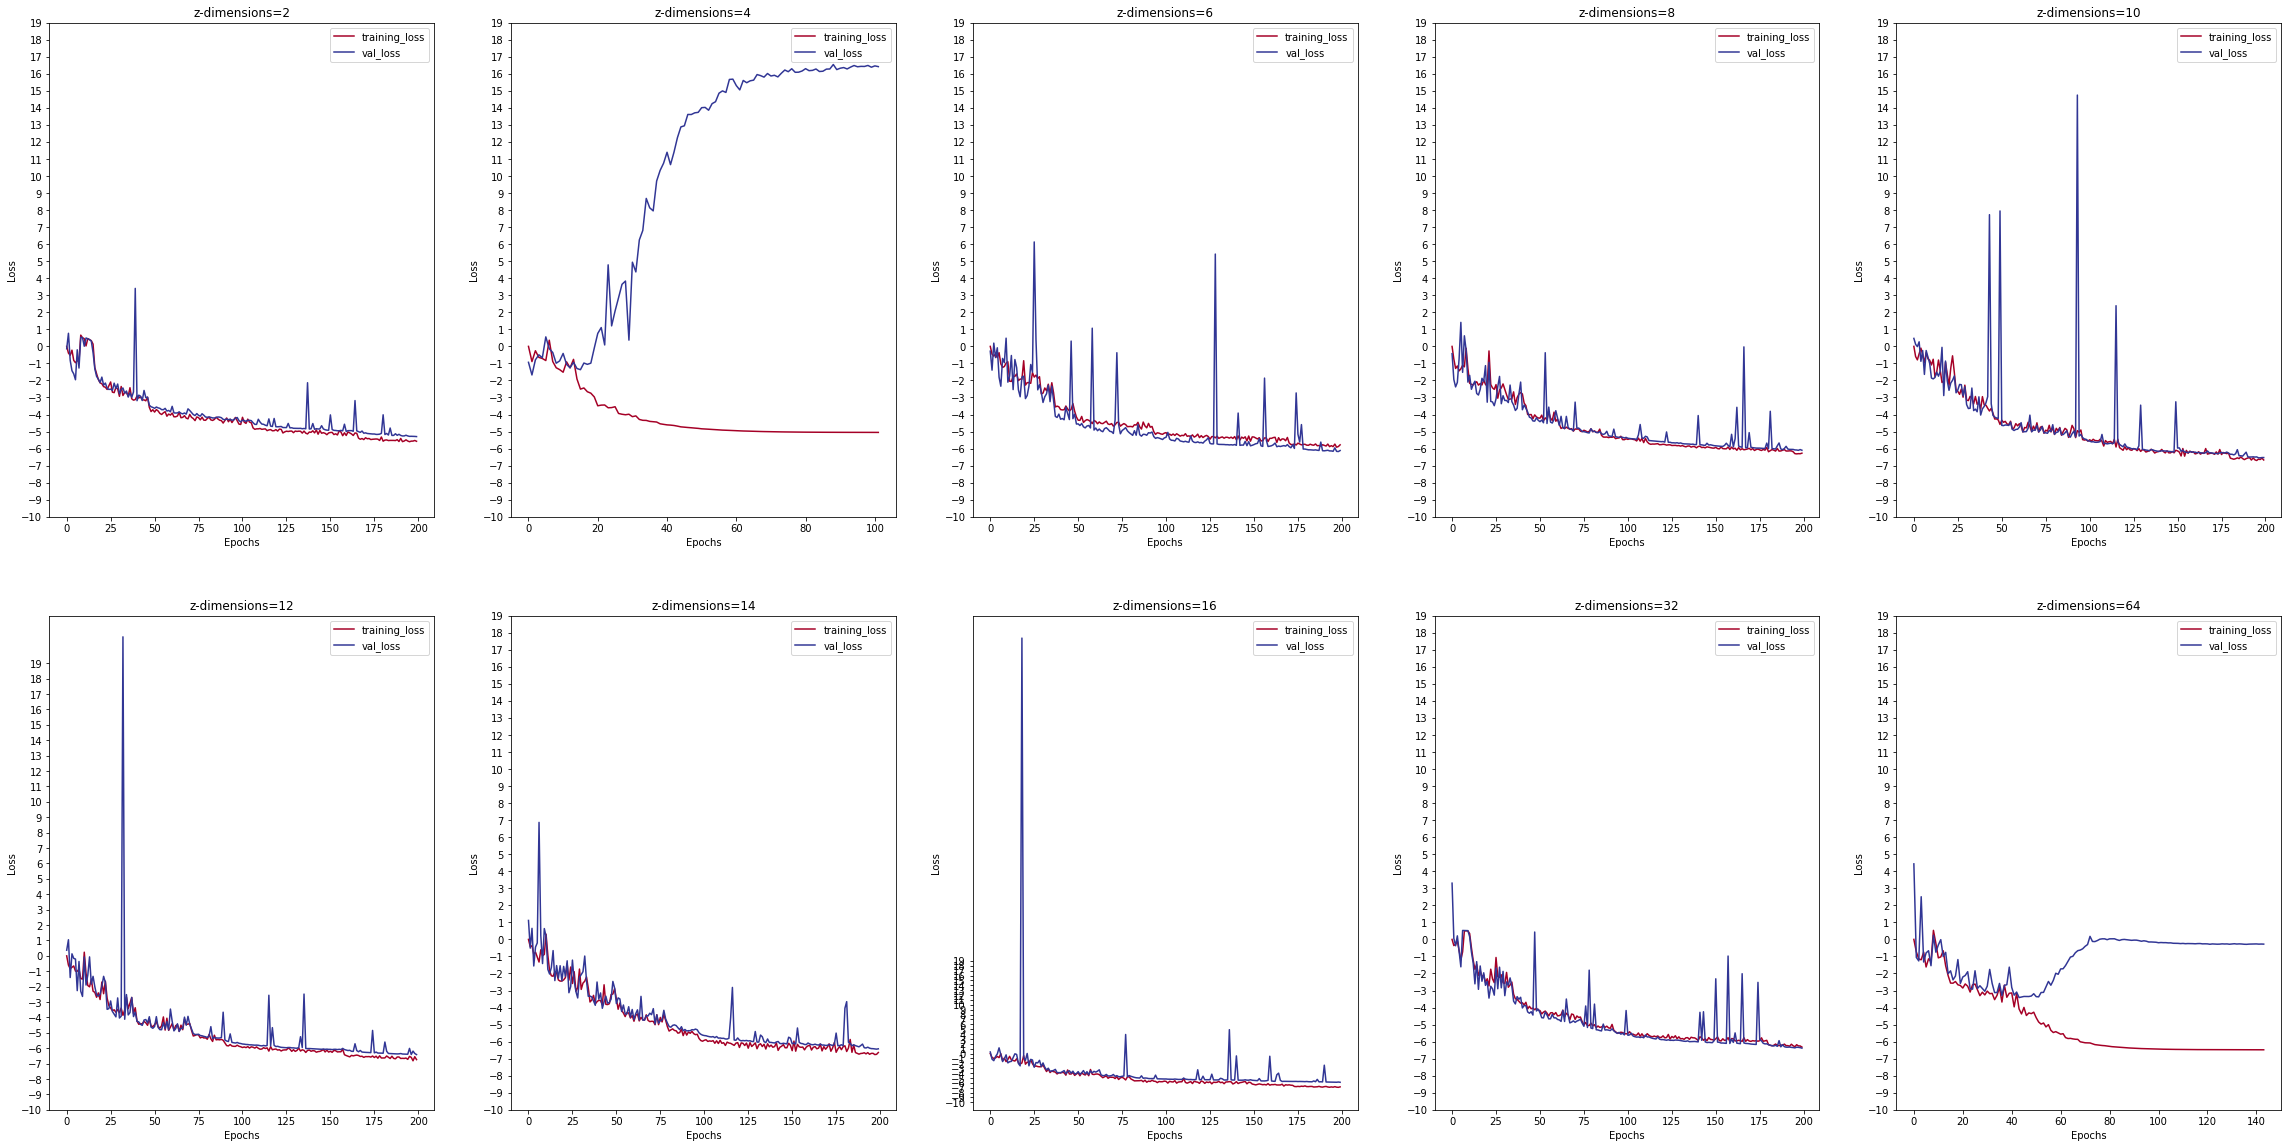

In [55]:
exp = ["14", "15", "16", "01", "17", "18", "19", "03", "05", "07"]
z_dim = ["2", "4", "6", "8", "10", "12", "14", "16", "32", "64"]
y=[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
x=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(40,20))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/Bias_Free/exp_" + j + "/plots/"
    data = np.load(directory_path + "train_loss.npy")
    ax[h, i].plot(data,label="training_loss")
    data = np.load(directory_path + "val_loss.npy")
    ax[h, i].plot(data,label="val_loss")
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("Loss")
    ax[h, i].set_yticks(np.arange(-10.0, 20.0, 1.0))
    colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1,len(ax[h, i].lines))]
    for a,b in enumerate(ax[h, i].lines):
        b.set_color(colors[a])
    ax[h, i].legend()
plt.show()

# Normal Plots

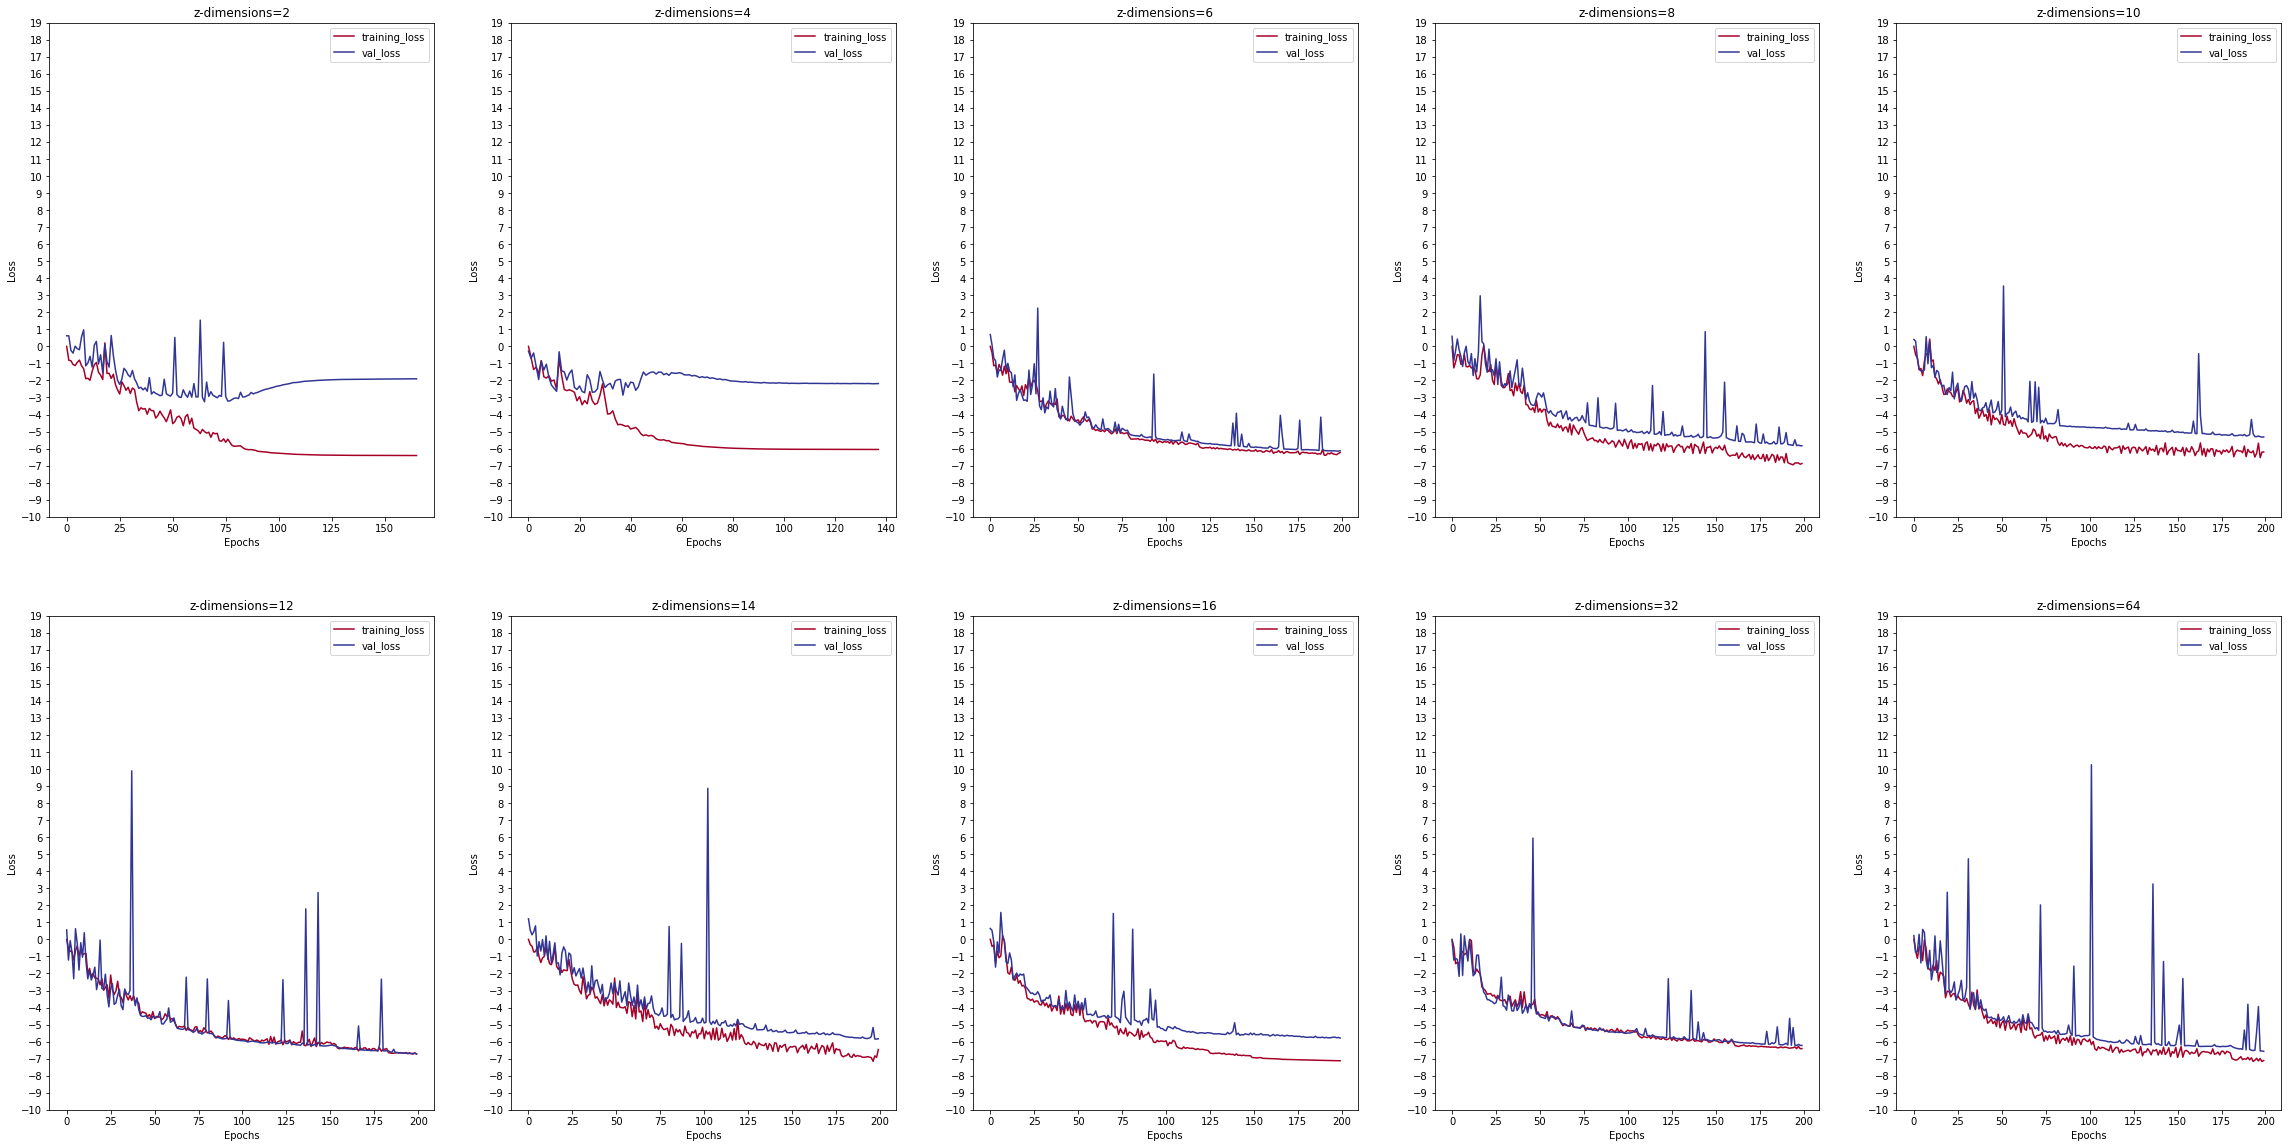

In [56]:
exp = ["14", "15", "16", "01", "17", "18", "19", "03", "05", "07"]
z_dim = ["2", "4", "6", "8", "10", "12", "14", "16", "32", "64"]
#x=[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
#y=[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
#fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20,30))
y=[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
x=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(40,20))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v4/exp_" + j + "/plots/"
    data = np.load(directory_path + "train_loss.npy")
    ax[h, i].plot(data,label="training_loss")
    data = np.load(directory_path + "val_loss.npy")
    ax[h, i].plot(data,label="val_loss")
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("Loss")
    ax[h, i].set_yticks(np.arange(-10.0, 20.0, 1.0))
    colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1,len(ax[h, i].lines))]
    for a,b in enumerate(ax[h, i].lines):
        b.set_color(colors[a])
    ax[h, i].legend()
plt.show()

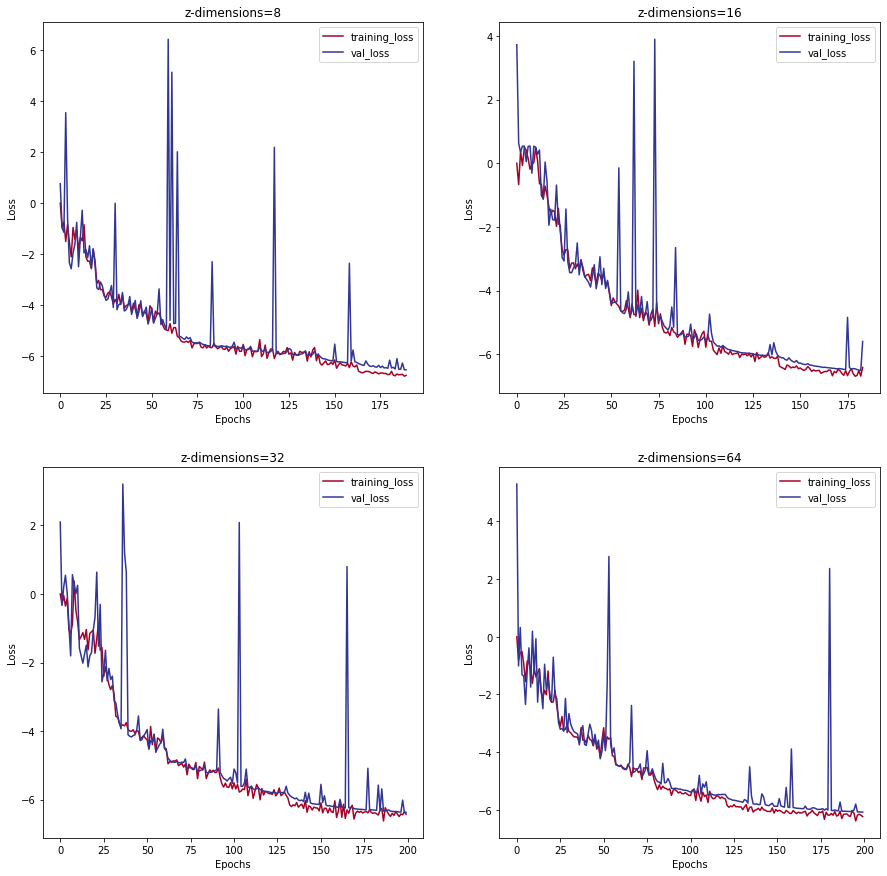

In [66]:
exp = ["02", "04", "06", "08"]
z_dim = ["8", "16", "32", "64"]
x=[0, 0, 1, 1]
y=[0, 1, 0, 1]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
for h, i, j, k in zip(x, y, exp, z_dim):
    directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline_v3/exp_" + j + "/plots/"
    data = np.load(directory_path + "train_loss.npy")
    ax[h, i].plot(data,label='training_loss')
    data = np.load(directory_path + "val_loss.npy")
    ax[h, i].plot(data,label='val_loss')
    ax[h, i].title.set_text("z-dimensions=" + k)
    ax[h, i].set_xlabel("Epochs")
    ax[h, i].set_ylabel("Loss")
    colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1,len(ax[h, i].lines))]
    for a,b in enumerate(ax[h, i].lines):
        b.set_color(colors[a])
    ax[h, i].legend()
plt.show()

# Plot for PSNR x Exp

In [42]:
def PSNR(original, restored):
    mse = np.mean((original - restored) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = max(np.unique(restored))
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def load_config(config_name):
    with open(config_name) as file:
        config_file = yaml.safe_load(file)

    return config_file

In [43]:
def evaluate(test_image_sequence, image_path, checkpoints_path):
    ground_truth = utils.image_transform(
        images_paths_list=[image_path],
        transform=False,
        seed=config_file["seed"]
    )[0]
    psnr_list = []
    for sequence in test_image_sequence:
        test_image = utils.image_transform(
            images_paths_list=[image_path],
            particle_noise_density=sequence,
            transform=True,
            seed=config_file["seed"]
        )[0]

        width, height = test_image.size
        image_sample = ToTensor()(test_image).view(1,1,height,width).cuda()
        models_list_length = sorted(pathlib.Path(checkpoints_path).rglob("*.net"))
        net = torch.load(models_list_length[-1])

        output = utils.predictMMSE(image_sample, 10, net, size=(height, width))
        psnr_list.append(PSNR(ground_truth, output))

    return psnr_list


In [45]:
#exp = ["14", "15", "01", "03", "05", "07"]
#z_dim = ["2", "4", "8", "16", "32", "64"]
#exp = ["02", "04", "06", "08"]
#z_dim = ["8", "16", "32", "64"]
exp = ["14", "15", "16", "01", "17", "18", "19", "03", "05", "07"]
z_dim = ["2", "4", "6", "8", "10", "12", "14", "16", "32", "64"]

sequence = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
directory_path = "/home/fahad/master_thesis/vanilla_vae/experiments/"

In [46]:
exp_list = []
for exp_no in exp:
    exp_name = "exp_" + exp_no
    config_file = load_config(directory_path + exp_name + ".yaml")
    checkpoints_path = os.path.join(config_file["save_default_path"], config_file["title"]) + "/checkpoints/"
    plots_path = os.path.join(config_file["save_default_path"], config_file["title"]) + "/plots/"
    images_folder_path = pathlib.Path(config_file["data_directory"]) / "val"
    image_path = utils.load_paths(
        data_directory=images_folder_path,
        n_samples=101,
    )[100]
    exp_list.append(evaluate(sequence, image_path, checkpoints_path))

# For 1x

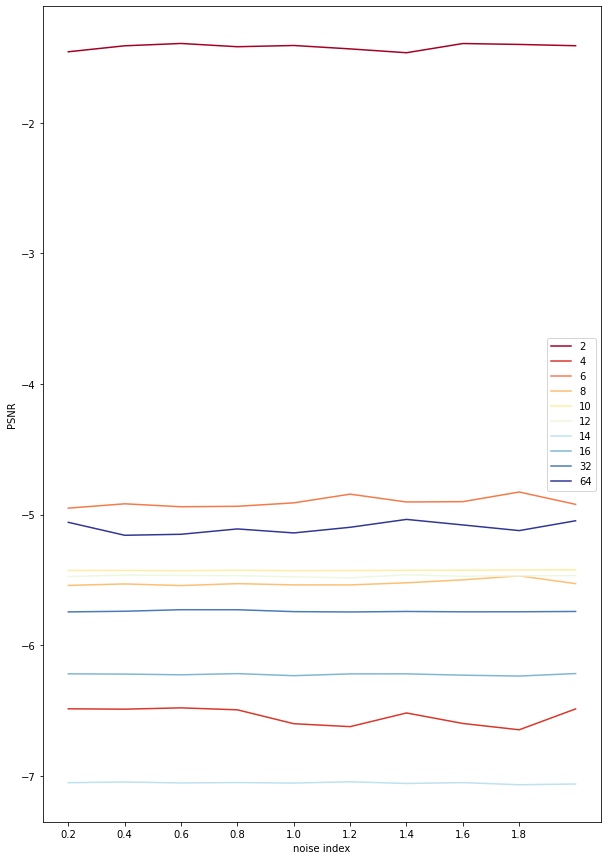

In [49]:
fig1 = plt.figure(figsize=(10,15))
ax1 = fig1.add_subplot(111)
#ax1.set_yticks(np.arange(14.0, 17.0, .1))
for i, j in zip(exp_list, z_dim):
    #ax1.scatter(sequence, np.array(i))
    ax1.plot(sequence, np.array(i), label=str(j))
ax1.set_xlabel("noise index")
ax1.set_ylabel("PSNR")
ax1.set_xticks(np.arange(0.2, 2.0, 0.2))
#ax1.set_yticks(np.arange(14.0, 18.0, 0.1))
colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
ax1.legend()

# For 2x

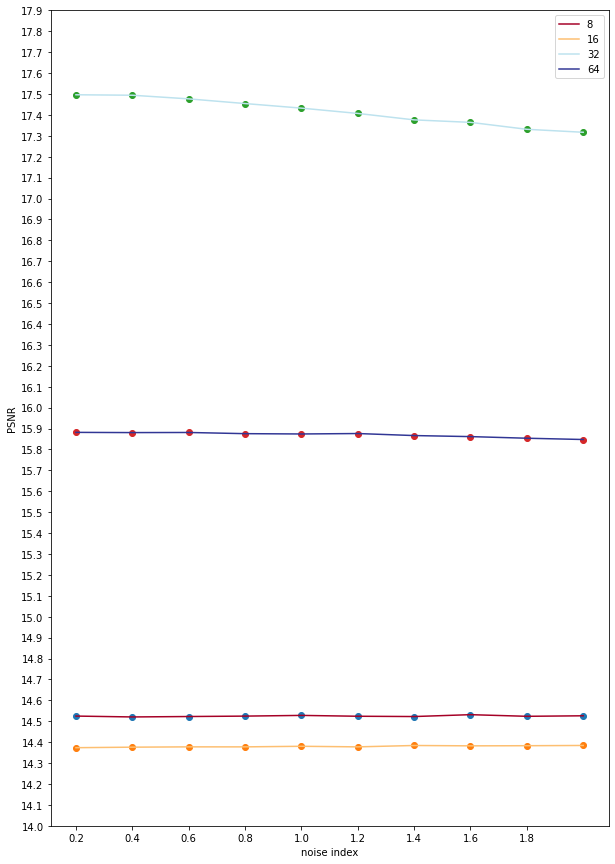

In [140]:
fig1 = plt.figure(figsize=(10,15))
ax1 = fig1.add_subplot(111)
#ax1.set_yticks(np.arange(14.0, 17.0, .1))
for i, j in zip(exp_list, z_dim):
    ax1.scatter(sequence, np.array(i))
    ax1.plot(sequence, np.array(i), label=str(j))
ax1.set_xlabel("noise index")
ax1.set_ylabel("PSNR")
ax1.set_xticks(np.arange(0.2, 2.0, 0.2))
ax1.set_yticks(np.arange(14.0, 18.0, 0.1))
colormap = plt.cm.RdYlBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
ax1.legend()

In [143]:
images_folder_path = pathlib.Path("/home/fahad/master_thesis/vanilla_vae/data/raw/simulated_clean_templates/") / "val"
image_path = utils.load_paths(
    data_directory=images_folder_path,
    n_samples=101,
)[100]
ground_truth = utils.image_transform(
    images_paths_list=[image_path],
    transform=False,
    seed=config_file["seed"]
)[0]

test_image = utils.image_transform(
    images_paths_list=[image_path],
    particle_noise_density=2.0,
    transform=True,
    seed=config_file["seed"]
)[0]

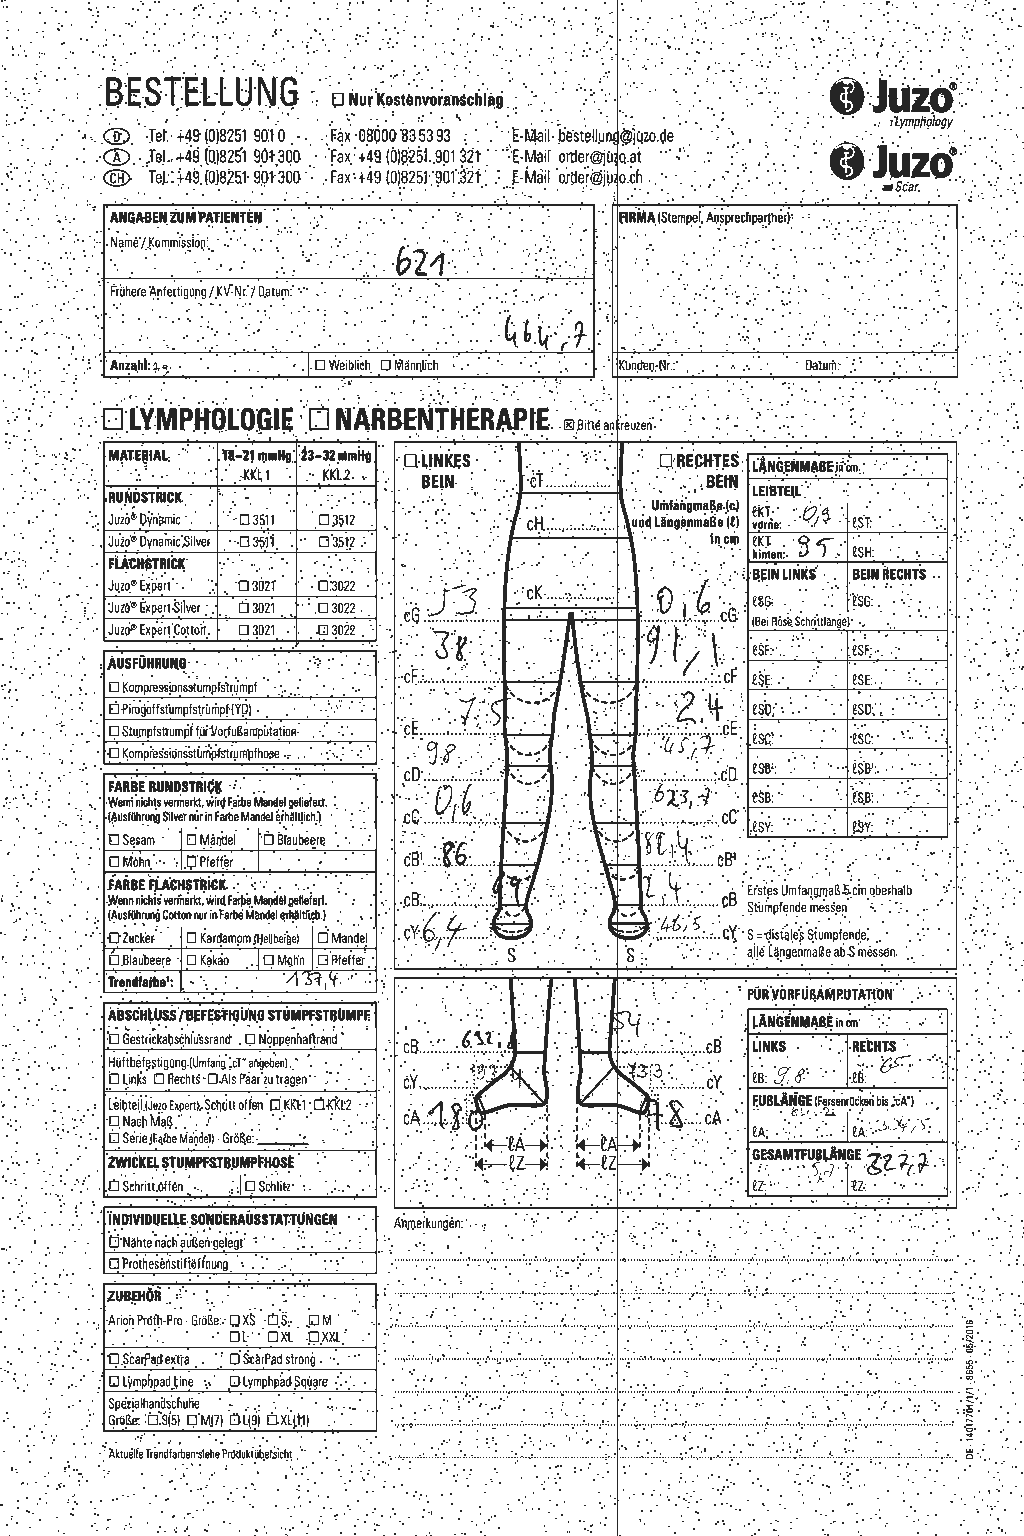

In [144]:
test_image